In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

# Lectura de bases de datos

In [3]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos = build_features.agregar_anio_mes_dia(df_diagnosticos, "fecha_atencion")
df_diagnosticos = df_diagnosticos.sort_values("fecha_atencion")


In [4]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos = build_features.formatear_fechas_procedimientos(df_procedimientos)
df_procedimientos = build_features.agregar_anio_mes_dia(df_procedimientos, "fecha_realizacion")
df_procedimientos = df_procedimientos.sort_values("fecha_realizacion")

fecha_minimo_procedimientos = min(df_procedimientos.fecha_realizacion)
fecha_maximo_procedimientos = max(df_procedimientos.fecha_realizacion)

cols_texto = df_procedimientos.select_dtypes(include="object").apply(lambda x: x.str.strip())
df_procedimientos.loc[:, cols_texto.columns] = cols_texto


## Analisis de cantidad de consultas y procedimientos

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03
El rango de fechas de procedimientos es entre 2020-01-02 00:00:00 y  2022-08-31 00:00:00


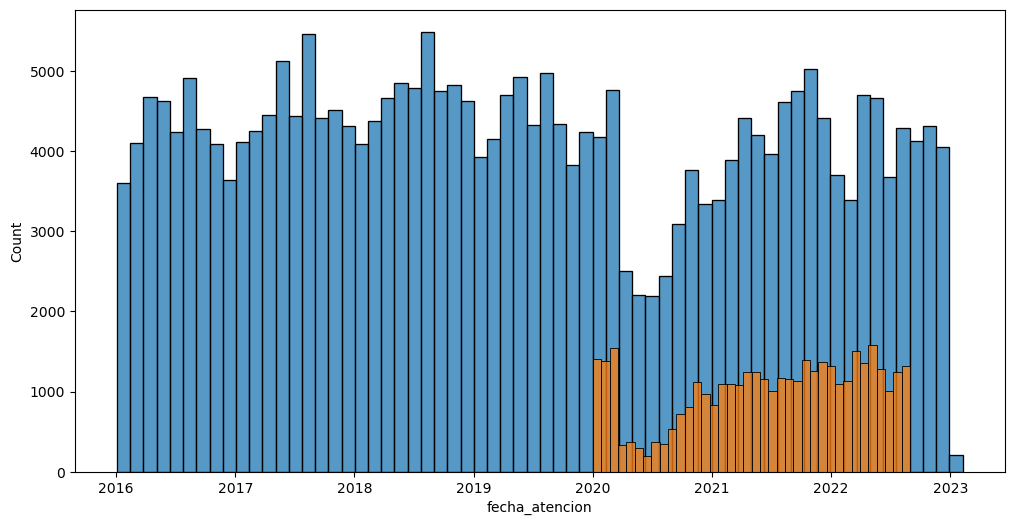

In [5]:
print(
    f"El rango de fechas de diagnosticos es entre {min(df_diagnosticos.fecha_atencion)} y "
    f" {max(df_diagnosticos.fecha_atencion)}"
)
print(
    f"El rango de fechas de procedimientos es entre {fecha_minimo_procedimientos} y "
    f" {fecha_maximo_procedimientos}"
)

sns.histplot(df_diagnosticos["fecha_atencion"])
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()


- Por lo tanto, ambas bases deben estar con el mismo rango temporal. Se procedera a filtrar
la base de diagnosticos

In [6]:
mask_fechas = (df_diagnosticos["fecha_atencion"] >= fecha_minimo_procedimientos) & (
    df_diagnosticos["fecha_atencion"] <= fecha_maximo_procedimientos
)

df_diagnosticos_acotado = df_diagnosticos[mask_fechas]


La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39484 procedimientos


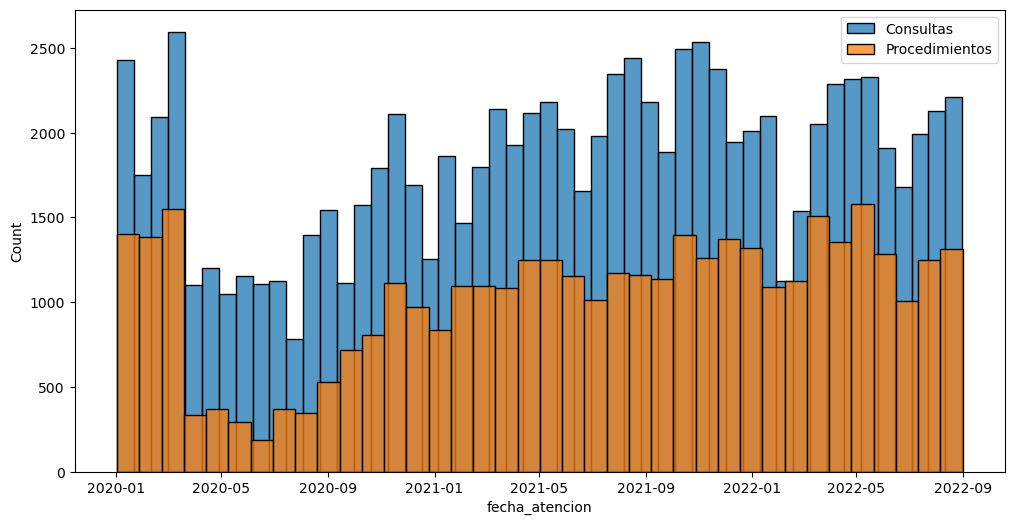

In [7]:
print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")

sns.histplot(df_diagnosticos_acotado["fecha_atencion"], label="Consultas")
sns.histplot(df_procedimientos["fecha_realizacion"], label="Procedimientos")
plt.legend()
plt.show()


- Luego, se eliminaran todos los registros que carezcan de una fecha de consulta o procedimientos

In [8]:
df_diagnosticos_acotado = df_diagnosticos_acotado.dropna(subset="fecha_atencion")
df_procedimientos = df_procedimientos.dropna(subset="fecha_realizacion")

print(f"La base de datos de consultas acotada tiene {df_diagnosticos_acotado.shape[0]} consultas")
print(f"La base de datos de procedimeintos tiene {df_procedimientos.shape[0]} procedimientos")


La base de datos de consultas acotada tiene 91916 consultas
La base de datos de procedimeintos tiene 39472 procedimientos


- Por lo tanto, la base de consultas carecia de fechas de atencion faltantes. Sin embargo, la
base de procedimientos presentaba 33 fechas faltantes.

# Analisis a lo largo del tiempo

En este analisis se quieren obtener los siguientes insights:

- Frecuencia de diagnosticos por anio
- Rango etario por anio
- Sexo por anio

Ademas, se quieren obtener las siguientes variables para los pacientes

- Prevision
- Servicio de Salud
- Comuna

Para esto, se utilizara la base de datos estadisticos y se uniran en base al id del paciente

In [9]:
datos_pacientes = (
    df_procedimientos.value_counts(
        ["id_paciente", "comuna_residencia", "prevision", "servicio_salud"]
    )
    .reset_index()
    .drop(columns=0)
)

indices_pacientes_unicos = datos_pacientes.groupby("id_paciente").head(1).index
pacientes_unicos = datos_pacientes.iloc[indices_pacientes_unicos]


In [10]:
df_diagnosticos_datos_paciente = pd.merge(
    df_diagnosticos, pacientes_unicos, how="left", on="id_paciente"
)


## Cantidad de consultas en la base de datos

In [11]:
print("La cantidad de consultas en la base de datos es:")
display(df_diagnosticos_datos_paciente.groupby("year")["codigo_diagnostico"].count())


La cantidad de consultas en la base de datos es:


year
2016    38165
2017    41103
2018    42470
2019    39425
2020    28623
2021    38732
2022    36919
2023        4
Name: codigo_diagnostico, dtype: int64

La base de datos REM (REM07 (Consultas Medicas) + REM32 (Consultas Medicas Telefonicas)) tiene la siguiente cantidad de consultas:

|year|Consultas Medicas Presenciales|Consultas Medicas Telefonicas|Total|
|----|---------------------|------|-----|
2016|34149||34149|
2017|33078||33078|
2018|32806||32806|
2019|36084||36084|
2020|14109|13617|27726|
2021|25715|6418|32133|

,year,consultas_bd,consultas_rem,diferencias
0,2016,38165,34149,4016
1,2017,41103,33078,8025
2,2018,42470,32806,9664
3,2019,39425,36084,3341
4,2020,28623,27726,897
5,2021,38732,32133,6599


La diferencia promedio de cantidad de consultas entre ambas bases de datos es: 5424 consultas
La distribucion de las diferencias en consultas es:


count       6.000000
mean     5423.666667
std      3253.874839
min       897.000000
25%      3509.750000
50%      5307.500000
75%      7668.500000
max      9664.000000
Name: diferencias, dtype: float64

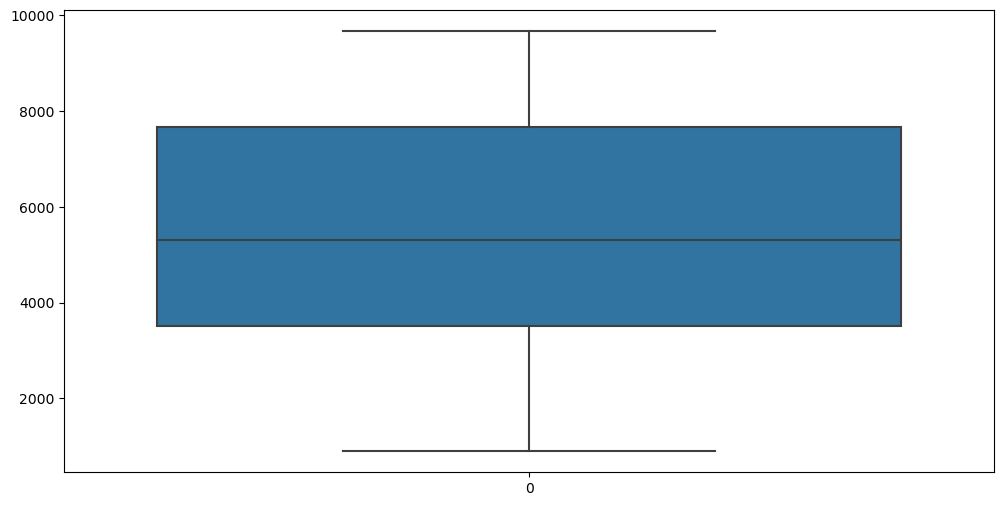

In [12]:
comparacion_rem_base_ambulatorio = pd.DataFrame(
    {
        "year": [2016, 2017, 2018, 2019, 2020, 2021],
        "consultas_bd": [38165, 41103, 42470, 39425, 28623, 38732],
        "consultas_rem": [34149, 33078, 32806, 36084, 27726, 32133],
    }
)

comparacion_rem_base_ambulatorio["diferencias"] = (
    comparacion_rem_base_ambulatorio["consultas_bd"]
    - comparacion_rem_base_ambulatorio["consultas_rem"]
)

display(comparacion_rem_base_ambulatorio)
print(
    f"La diferencia promedio de cantidad de consultas entre ambas bases de datos es: {comparacion_rem_base_ambulatorio.diferencias.mean():.0f} consultas"
)
print("La distribucion de las diferencias en consultas es:")
display(comparacion_rem_base_ambulatorio.diferencias.describe())
sns.boxplot(comparacion_rem_base_ambulatorio.diferencias)
plt.show()


Por lo tanto, la diferencia entre la base de datos de consultas y REM presenta una diferencia
promedio de **5424** consultas con una diferencia minima de 897 consultas (en 2020) y una diferencia
maxima de 9664 (en 2018).

## Analisis Sociodemografico de la base de datos

In [13]:
agrupacion_estatica = ["ano"]
variable_a_contar = "codigo_diagnostico"

vars_a_obtener_detalle = [
    "sexo",
    "rango_etario_primera_consulta",
    "comuna_residencia",
    "prevision",
    "servicio_salud",
]


In [14]:
df_diagnosticos_largo_4 = df_diagnosticos_datos_paciente[
    df_diagnosticos_datos_paciente.codigo_diagnostico.str.len() == 4
]

In [15]:
resultado_sociodemo = build_features.obtener_desglose_sociodemografico(
    df_diagnosticos_largo_4, agrupacion_estatica, vars_a_obtener_detalle, variable_a_contar
)

In [16]:
resultado_sociodemo["global"] = build_features.leer_cie_y_unir_a_datos(
    resultado_sociodemo["global"], "codigo_diagnostico"
)


In [17]:
with pd.ExcelWriter(
    "../data/processed/tableros_powerbi/distribucion_sociodemografica.xlsx"
) as file:
    for nombre_hoja, df_a_guardar in resultado_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

## Diagnosticos mas relevantes entre 2016 y 2023

Posteriormemnte, se quieren seleccionar los 20 diagnósticos más frecuentes para cada uno de los
años. Luego, se generará una lista conteniendo solamente los diagnósticos únicos de las listas
anteriores.

In [18]:
diags_mas_relevantes = (
    resultado_sociodemo["global"].groupby("ano").head(20).codigo_diagnostico.unique()
)
consultas_totales_mas_relevantes = resultado_sociodemo["global"][
    resultado_sociodemo["global"]["codigo_diagnostico"].isin(diags_mas_relevantes)
]

In [19]:
print(f"Los diagnosticos más relevantes para el Hospital del Tórax en el ámbito ambulatorio"
      f" son: \n{diags_mas_relevantes}")

print(f"> {len(diags_mas_relevantes)} diagnosticos")

Los diagnosticos más relevantes para el Hospital del Tórax en el ámbito ambulatorio son: 
['C34X' 'J841' 'G473' 'J450' 'I99X' 'J47X' 'J849' 'J449' 'C349' 'J848'
 'J84X' 'I50X' 'F17X' 'C341' 'I441' 'I498' 'J459' 'R91X' 'I49X' 'D381'
 'I459' 'XXXX' 'I350' 'J432' 'I255' 'Q208' 'Z942' 'C340' 'J67X' 'E849'
 'R060' 'Z941']
> 32 diagnosticos


In [20]:
resumen_consultas_mas_relevantes = pd.pivot_table(
    consultas_totales_mas_relevantes,
    values="conteo_global",
    index=["codigo_diagnostico", "Descripción"],
    columns="ano",
    aggfunc=np.sum,
)

resumen_consultas_totales = pd.pivot_table(
    resultado_sociodemo["global"],
    values="conteo_global",
    index=["codigo_diagnostico", "Descripción"],
    columns="ano",
    aggfunc=np.sum,
)

comparacion_total_mas_relevantes = pd.concat(
    [resumen_consultas_mas_relevantes.sum(), resumen_consultas_totales.sum()],
    axis=1,
    keys=["Mas Relevantes", "Totales"],
)
comparacion_total_mas_relevantes["porcentaje_del_total"] = (
    comparacion_total_mas_relevantes["Mas Relevantes"] / comparacion_total_mas_relevantes["Totales"]
)

diccionario_resultado = {
    "diagnosticos_mas_relevantes": resumen_consultas_mas_relevantes,
    "comparacion_del_total": comparacion_total_mas_relevantes,
    "totales": resumen_consultas_totales,
    "BD_mas_relevantes": consultas_totales_mas_relevantes,
}

with pd.ExcelWriter("../data/interim/diagnosticos_mas_relevantes_ambulatorios.xlsx") as file:
    for nombre_hoja, df_a_guardar in diccionario_resultado.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja)



In [21]:
display(comparacion_total_mas_relevantes)
display(resultado_sociodemo["global"].groupby("ano")["codigo_diagnostico"].nunique())

,Mas Relevantes,Totales,porcentaje_del_total
ano,,,
2016,23868.0,37578.0,0.635159
2017,25690.0,40039.0,0.641624
2018,27511.0,41194.0,0.667840
2019,25506.0,38401.0,0.664201
2020,18320.0,27798.0,0.659040
2021,25008.0,37320.0,0.670096
2022,23294.0,35413.0,0.657781
2023,4.0,4.0,1.000000


ano
2016    1022
2017     967
2018     925
2019     928
2020     780
2021     874
2022     889
2023       3
Name: codigo_diagnostico, dtype: int64

- En la tabla anterior se muestran la cantidad de diagnosticos distintos por año en las consultas
ambulatorias

- Los resultados anteriores indican que los 20 diagnosticos mas frecuentes entre 2016 y 2023
cubren aproximadamente el 66% de todas las consultas anuales.

- Esto significa que 32 (aproximadamente el 3% al 4% de los diagnosticos totales) diagnosticos
tienen una cobertura del 66% de las consultas totales del ambito ambulatorio

# Analisis de procedimientos y diagnosticos

- En este apartado se quiere realizar un analisis de cuales procedimientos se le realizan a cada
diagnostico en ambulatorios. La primera forma de resolverlo es de la siguiente forma:

## 2. Obtener el diagnostico del paciente y llevarlo a los procedimientos

- La idea es enlazar solamente por ID_paciente el procedimiento/diagnostico. Sin embargo, un mismo
paciente puede tener diversos diagnosticos a lo largo del tiempo. Debido a lo anterior, es que se
necesita identificar el diagnostico que este mas cerca de la fecha del procedimiento

- Primero se debe saber si es que todos los pacientes de procedimientos estan en diagnosticos:

In [22]:
pacientes_consultas = set(df_diagnosticos_acotado.id_paciente.unique())
pacientes_procedimientos = set(df_procedimientos.id_paciente.unique())
diferencia_pacientes_consultas = pacientes_consultas - pacientes_procedimientos
diferencia_pacientes_procedimientos = pacientes_procedimientos - pacientes_consultas
pacientes_en_ambas = pacientes_consultas & pacientes_procedimientos

print(f"> La base de consultas tiene {len(pacientes_consultas)} pacientes distintos")
print(f"> La base de procedimientos tiene {len(pacientes_procedimientos)} pacientes distintos\n")
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_consultas)} pacientes que solo estan "
    f"en las consultas"
)
print(
    f"> Hay una diferencia de {len(diferencia_pacientes_procedimientos)} pacientes que solo estan"
    f" en procedimientos\n"
)
print(f"> Hay {len(pacientes_en_ambas)} pacientes que estan en ambas bases de datos")

> La base de consultas tiene 23213 pacientes distintos
> La base de procedimientos tiene 14737 pacientes distintos

> Hay una diferencia de 11020 pacientes que solo estan en las consultas
> Hay una diferencia de 2544 pacientes que solo estan en procedimientos

> Hay 12193 pacientes que estan en ambas bases de datos


- La diferencia entre pacientes puede ocurrir debido a que ninguno de estos se ha hecho algun
procedimiento durante su consulta.

- Para reducir el costo computacional, se dejaran solamente los pacientes que esten en ambas bases
de datos

In [23]:
diags_pacientes_comunes = df_diagnosticos_acotado[
    df_diagnosticos_acotado.id_paciente.isin(pacientes_en_ambas)
]
proced_pacientes_comunes = df_procedimientos[df_procedimientos.id_paciente.isin(pacientes_en_ambas)]


- Ahora, en la base de procedimientos se deben obtener las duplas unicas entre id_paciente y
fecha_realizacion para reducir el costo computacional en la busqueda.

In [24]:
dupla_pacientes = (
    proced_pacientes_comunes[["id_paciente", "fecha_realizacion"]].value_counts().index
)

In [25]:
resultados_pacientes = []
for id_paciente, fecha_procedimiento in dupla_pacientes:
    df_paciente = diags_pacientes_comunes.query("id_paciente == @id_paciente")
    diag_mas_cercano = build_features.obtener_diag_mas_cercano(df_paciente, fecha_procedimiento)
    resultados_pacientes.append(diag_mas_cercano)


In [26]:
pacientes_y_diags = pd.DataFrame(resultados_pacientes, index=dupla_pacientes)
pacientes_y_diags.columns = ["codigo_diagnostico"]
proced_comunes_indice = proced_pacientes_comunes.set_index(["id_paciente", "fecha_realizacion"])
union_procedimientos_2 = pd.merge(
    proced_comunes_indice, pacientes_y_diags, how="inner", left_index=True, right_index=True
).reset_index()


In [27]:
union_procedimientos_2["llave_sesion"] = union_procedimientos_2["id_paciente"] + union_procedimientos_2["fecha_realizacion"].astype(str)

In [28]:
cantidad_procedimientos_por_diagnostico = (
    union_procedimientos_2.groupby(["codigo_diagnostico"])["glosa"]
    .value_counts()
    .reset_index(name="cantidad_procedimientos_diag")
)

cantidad_sesiones_unicas_por_diagnostico = (
    union_procedimientos_2.groupby(["codigo_diagnostico"])["llave_sesion"]
    .nunique()
    .reset_index(name="sesiones_unicas_diag")
)

procedimientos_por_sesiones_unicas = pd.merge(cantidad_procedimientos_por_diagnostico, cantidad_sesiones_unicas_por_diagnostico, how="left", on="codigo_diagnostico")
procedimientos_por_sesiones_unicas["porcentaje_de_procedimiento_por_sesion"] = round((procedimientos_por_sesiones_unicas["cantidad_procedimientos_diag"] / procedimientos_por_sesiones_unicas["sesiones_unicas_diag"]) * 100, 2)

In [39]:
procedimientos_de_diags_mas_relevantes = procedimientos_por_sesiones_unicas[procedimientos_por_sesiones_unicas["codigo_diagnostico"].isin(diags_mas_relevantes)]
procedimientos_de_diags_mas_relevantes.to_csv("../data/interim/procedimientos_por_diagnostico.csv",
index=False,
encoding="latin-1")